In [58]:

import warnings 
warnings.filterwarnings(action='ignore')
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import imageio
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from keras import backend as K
import colorsys
import random
from io import BytesIO
from keras.models import load_model

%matplotlib inline

In [59]:
# Preprocess input images to match model input size

def preprocess_image(img_path, model_image_size):
    
    image = Image.open(img_path)
        
    # Retrieve image shape (necessary to scale predicted bounding boxes later on)
    image_shape = image.size[::-1]
    
    # Resize image to correspond to model image size with BICUBIC interpolation mode (cubic spline interpolation)
    resized_image = image.resize(model_image_size, Image.BICUBIC)
    
    # Convert image to a numpy array
    image_data = np.array(resized_image, dtype='float32')
    
    # Normalize image
    image_data /= 255.
    
    # Add batch dimension 
    image_data = np.expand_dims(image_data, 0)  
    
    # Display the image 
    plt.show()
    
    return image, image_data, image_shape

In [60]:
# Load anchor boxes dimensions (predefined)

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

In [61]:
anchors = read_anchors('./model_data/yolo_anchors.txt')
anchors

array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

In [62]:

# Load labels from COCO dataset 

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

In [63]:
class_names = read_classes('./model_data/coco_classes.txt')
class_names[:10]

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light']

In [64]:
# Generate colors to represent classes on the image (for drawing bounding boxes)

def generate_colors(class_names):
    
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    
    # Fixed seed for consistent colors across runs
    random.seed(10101)  
    
    # Shuffle colors to decorrelate adjacent classes
    random.shuffle(colors)  
    
    # Reset seed to default
    random.seed(None)  
    
    return colors

In [65]:
sess = K.get_session()

In [66]:
# Load pre-trained model from the official YOLO site, according to instructions in this repo: 
# https://github.com/allanzelener/YAD2K
model = load_model('./model_data/yolov2.h5')

In [67]:
# Retrieve features from the final layer of the model 
features = model.output

In [68]:
# Convert model features to bounding box parameters

def features_to_boxes(features, anchors, num_classes):
   
    num_anchors = len(anchors)
    
    # Reshape to batch, height, width, num_anchors, box_params
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model
    conv_dims = K.shape(features)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    conv_width_index = K.tile(
        K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(features))

    features = K.reshape(
        features, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(features))

    box_xy = K.sigmoid(features[..., :2])
    box_wh = K.exp(features[..., 2:4])
    box_confidence = K.sigmoid(features[..., 4:5])
    box_class_probs = K.softmax(features[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_xy, box_wh, box_confidence, box_class_probs

In [69]:
yolo_outputs = features_to_boxes(features, anchors, len(class_names))

In [70]:
# Evaluate detected objects

def yolo_evaluate(yolo_outputs, image_shape=(720., 1280.), max_output_size=10, score_threshold=.6, iou_threshold=.5):
    
    # Unpack bounding box params 
    xy, wh, confidence, class_probs = yolo_outputs
    
    # Convert boxes information from (middle-point-coordinates, width-height) to corners coordinates 
    boxes = boxes_to_corners(xy, wh)
    
    # Step 1: eliminate boxes with low probabilities - filter boxes with scores lower than the threshold
    scores, boxes, classes = filter_boxes(confidence, boxes, class_probs, score_threshold)
    
    # Step 2: eliminate boxes with non-max scores and high overlap - filter boxes with IoU lower than the threshold
    scores, boxes, classes = non_max_suppression(scores, boxes, classes, max_output_size, iou_threshold)
    
    # Scale boxes to match input image size
    boxes = scale_boxes(boxes, image_shape)
    
    return scores, boxes, classes

In [71]:
# Helper function: convert boxes to corners

def boxes_to_corners(box_xy, box_wh):
   
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]])  # x_max

In [72]:
# Helper function: eliminate boxes data with low predicted probability

def filter_boxes(confidence, boxes, class_probs, threshold = 0.6):
    
    # Compute the score for each box (object probability multiplied by class probability)
    scores = confidence * class_probs
    
    # Find class with maximum score for each box and respective score
    classes_with_max_score = K.argmax(scores, axis=-1)
    max_scores = K.max(scores, axis=-1)
    
    # Define a mask (binary filter) to discard boxes with score lower than the set threshold
    mask = (max_scores >= threshold)
    
    # Apply the mask to discard boxes data with the score lower than the set threshold
    scores = tf.boolean_mask(max_scores, mask)
    boxes =  tf.boolean_mask(boxes, mask)
    classes = tf.boolean_mask(classes_with_max_score, mask)
    
    return scores, boxes, classes

In [73]:
# Helper function: perform non-max suppression to make sure algorithm detects objects only once

def non_max_suppression(scores, boxes, classes, max_output_size = 10, iou_threshold = 0.5):
    
    # Initialize max_output_size variable (we need it later to perform tf.image.non_max_suppression)
    max_output_size_tensor = K.variable(max_output_size, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_output_size_tensor]))
    
    # Return indices from the boxes data to keep: eliminate non-max scores with a significant overlap with the max score
    remaining_indices = tf.image.non_max_suppression(boxes, scores, max_output_size_tensor, iou_threshold=0.5)
    
    # Get rid of bounding box data with non-max scores and significant overlap with max score 
    scores = K.gather(scores, remaining_indices)
    boxes = K.gather(boxes, remaining_indices)
    classes = K.gather(classes, remaining_indices)
    
    return scores, boxes, classes

In [74]:
# Helper function: Scale predicted boxes to make them drawble on the image (normalize boxes by image dimensions)

def scale_boxes(boxes, image_shape):
    
    # Retrieve image dimensions
    height = image_shape[0]
    width = image_shape[1]
    
    # Stack and reshape image dimensions to correspond to boxes coordinates (b_x, b_y, b_h, b_w)
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    image_dims = K.cast(image_dims, 'float32')
    # Normalize boxes by image dimensions
    boxes = boxes * image_dims
    
    return boxes

In [75]:
# Helper function: draw selected bounding boxes on the image 

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names):
    
    # Generate colors for drawing predicted bounding boxes
    colors = generate_colors(class_names)
    
    # Load a font - workaround for ImageFont.truetype OSError
    file = open("./font/FiraMono-Medium.otf", "rb")
    bytes_font = BytesIO(file.read())
    font = ImageFont.truetype(bytes_font, size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    file.close()
    
    # Set bounding box line thickness
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        
        # Retrieve box parameters
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]
        
        # Create output label
        label = '{} {:.2f}'.format(predicted_class, score)
        
        # Draw the bounding box on the image
        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        
        # Retrieve box coordinates
        top, left, bottom, right = box
        
        # Limit bounding box coordinates to the image dimensions
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        
        # Set origin for the label text
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

In [76]:

# Make predictions and draw predicted bounding boxes on the input image

def predict(sess, img_path):
    
    # Preprocess input images to match model input size 
    image, image_data, image_shape = preprocess_image(img_path, model_image_size = (608, 608))
    
    # Optimize: perform forward propagation 
    out_scores, out_boxes, out_classes = sess.run(yolo_evaluate(yolo_outputs, image_shape), feed_dict={model.input: image_data,
                                                                                                       K.learning_phase(): 0})
    # Draw bounding boxes on the input image 
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names)

    # Save edited image
    path, filename = os.path.split(img_path)
    image.save(os.path.join('./images/out', filename), quality=90)
    
    # Display the image 
    output_image = imageio.imread(os.path.join('./images/out/', filename))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

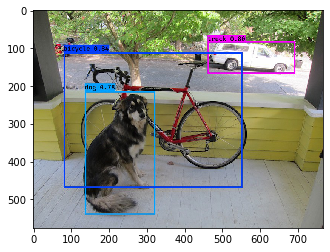

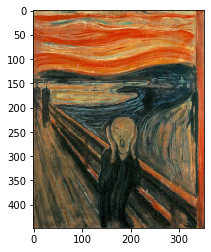

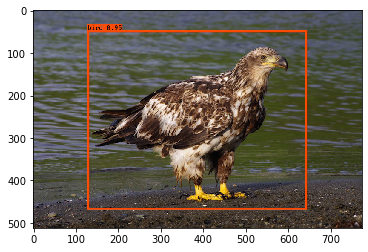

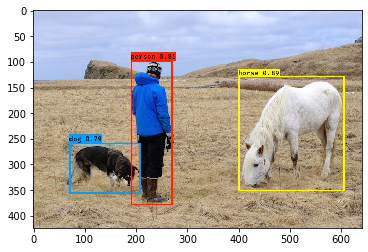

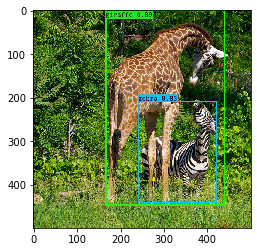

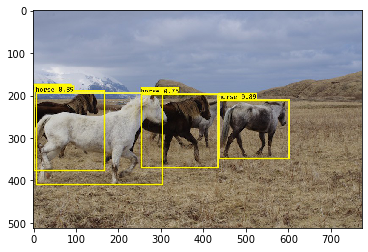

In [77]:
for filename in os.listdir('./images'):
    if filename.endswith('.jpg'):
        predict(sess, './images/' + str(filename))